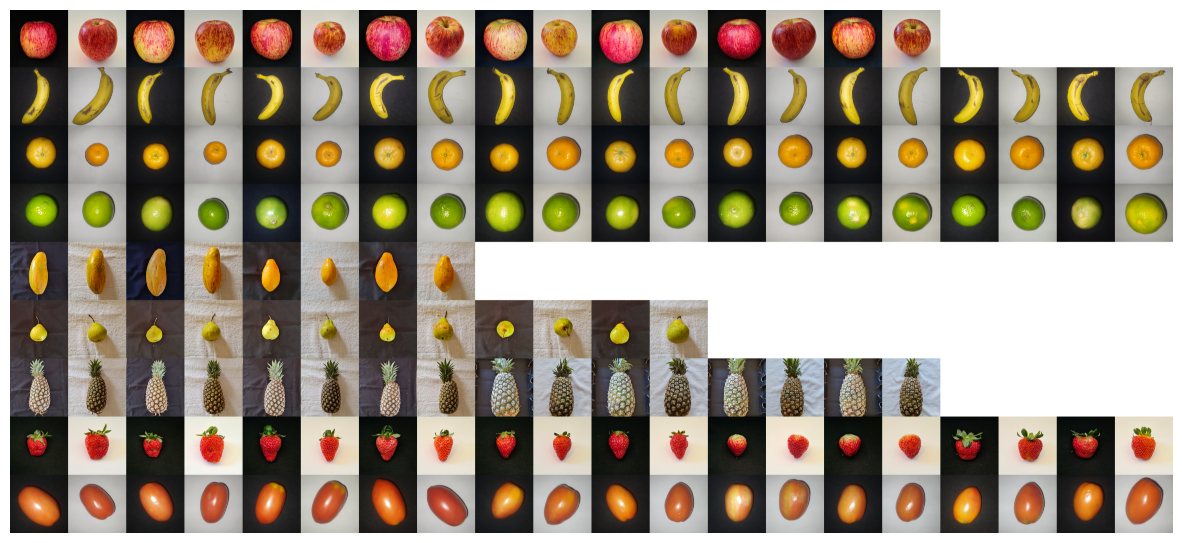

In [ ]:
""" Script para importar e descompactar imagens da base de dados do github, além de mostrá-las utilizando o skimage.util.montage  """

import requests
import tarfile
import os
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from skimage.util import montage

Image_height = 1000
Image_width = 1000
Image_channels = 4
Number_of_images = 20
Current_number_of_images = 0
image_list = []

White_image = np.full((Image_height, Image_width, Image_channels), 255, dtype=np.uint8)

def download_and_extract(github_url, folder_name):
    # Cria o diretório se não existir
    os.makedirs(folder_name, exist_ok=True)

    # Baixa o arquivo tar.gz
    response = requests.get(github_url)
    tar_data = BytesIO(response.content)

    # Extrai o conteúdo do arquivo tar.gz
    with tarfile.open(fileobj=tar_data, mode="r:gz") as tar:
        tar.extractall(path=folder_name)

def process_fruit_images(folder_name, image_list):
    Current_number_of_images = 0;

    # Lista recursivamente os arquivos na pasta extraída
    extracted_files = []
    for root, dirs, files in os.walk(folder_name):
        for file_name in files:
            extracted_files.append(os.path.join(root, file_name))

    # Ordena a lista de arquivos por nome
    extracted_files.sort()

    #print("Arquivos extraídos para", folder_name, ":", extracted_files)

    # Exibe as imagens
    for file_path in extracted_files:
        image = Image.open(file_path)
        image_array = np.array(image)
        # Verifica a forma da imagem
        if len(image_array.shape) == 3 and image_array.shape[2] == 3:
            # Adiciona um canal alfa (255) para imagens RGB
            image_array = np.concatenate([image_array, np.ones_like(image_array[:, :, :1]) * 255], axis=-1)
            image_list.append(image_array)
        else:
            # Mantém as imagens que já têm um canal alfa ou não são RGB
            image_list.append(image_array)
        Current_number_of_images += 1

    while(Current_number_of_images < Number_of_images):
        image_list.append(White_image)
        Current_number_of_images += 1

def create_montage(image_list):
    Montage = montage(image_list, grid_shape=(Number_of_classes, Number_of_images), channel_axis=-1)
    # Exiba a montagem
    plt.figure(figsize=(15,30))
    plt.imshow(Montage)
    plt.axis('off')
    plt.show()

# Lista de frutas e URLs correspondentes
fruits_and_urls = [
    ("Apple", "https://github.com/schmoellerIuri/FruitClassifier/raw/master/Images/Apple.tar.gz"),
    ("Banana", "https://github.com/schmoellerIuri/FruitClassifier/raw/master/Images/Banana.tar.gz"),
    ("Clementine", "https://github.com/schmoellerIuri/FruitClassifier/raw/master/Images/Clementine.tar.gz"),
    ("Lemon", "https://github.com/schmoellerIuri/FruitClassifier/raw/master/Images/Lemon.tar.gz"),
    ("Papaya", "https://github.com/schmoellerIuri/FruitClassifier/raw/master/Images/Papaya.tar.gz"),
    ("Pear", "https://github.com/schmoellerIuri/FruitClassifier/raw/master/Images/Pear.tar.gz"),
    ("Pineapple", "https://github.com/schmoellerIuri/FruitClassifier/raw/master/Images/Pineapple.tar.gz"),
    ("Strawberry", "https://github.com/schmoellerIuri/FruitClassifier/raw/master/Images/Strawberry.tar.gz"),
    ("Tomato", "https://github.com/schmoellerIuri/FruitClassifier/raw/master/Images/Tomato.tar.gz"),
]

Number_of_classes= len(fruits_and_urls)

# Processa cada fruta
for fruit, url in fruits_and_urls:
    download_and_extract(url, fruit)
    process_fruit_images(fruit, image_list)

# Cria um único montage com todas as frutas
create_montage(image_list)
